IA & Data science (LU3IN0226) -- 2022-2023
--------
*&copy; Equipe pédagogique: Christophe Marsala, Olivier Schwander, Jean-Noël Vittaut.*

# TD-TME06: les arbres de décision (catégoriel)

L'objectif de ce notebook est d'implémenter un algorithme d'apprentissage supervisé qui travaille sur des données catégorielles, l'algorithme de construction d'arbres de décision.


## Préparation du notebook

<font size="+1" color="RED">**[Q]**</font> **Indiquer dans la boîte ci-dessous vos noms et prénoms :**

Noura ALJANE

<font color="RED" size="+1">**[Q]**</font> **Renommer ce fichier ipython**

Comme lors des précédents TME, renommer ce fichier en incluant les noms de votre binôme.


<font color="RED" size="+1">**[Q]**</font> **Mise à jour de la librairie `iads`**

En premier lieu, vérifier que votre librairie `iads` est bien à jour et qu'elle inclut bien tout ce que vous avez programmé jusque là.

In [2]:
# Importation des librairies standards:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
%matplotlib inline  

# Importation de votre librairie iads:
# La ligne suivante permet de préciser le chemin d'accès à la librairie iads
import sys
sys.path.append('../')   # iads doit être dans le répertoire frère du répertoire courant !

# Importation de la librairie iads
import iads as iads

# importation de ClassifiersX.shape[1]
from iads import Classifiers as cl

# importation de utils
from iads import utils as ut

# importation de evaluation
from iads import evaluation as ev

# commande TRES utile pour recharger automatiquement le code que vous modifiez dans les modules
%load_ext autoreload
%autoreload 2

<font color="RED" size="+1">**[Q]**</font> Pour conclure le TME 4, écrire la fonction `validation_croisee` qui prend en argument un algorithme d'apprentissage $C$, un dataset $DS$ et un nombre d'itérations voulues, et rend un triplet composé de la liste des accuracies obtenues, la moyenne de ces accuraciées et leur écart type.

Cette fonction utilise les fonctions `crossval_strat` et `analyse_perfs` du TME 4, vous commencerez par copier ces 2 fonctions dans votre librairie `iads`, dans le fichier `evaluation.py` (importé sous l'alias `ev`).

**Remarque**: dans la fonction, il peut être important de copier (correctement, avec `deepcopy` de la librairie `copy`) le classifieur pour pouvoir l'entraîner plusieurs fois indépendamment.

In [3]:
import copy

def validation_croisee(C, DS, nb_iter):
    """ Classifieur * tuple[array, array] * int -> tuple[ list[float], float, float]
    """
    X, Y = DS   
    perf = []
    
    
    
    newC = copy.deepcopy(C)
    for i in range(nb_iter):
        X_train, Y_train, X_test, Y_test = ev.crossval_strat(X, Y, nb_iter, i)
        newC.train(X_train, Y_train)
        perf.append(newC.accuracy(X_test, Y_test))    

    (perf_moy, perf_sd) = ev.analyse_perfs(perf)
    return (perf, perf_moy, perf_sd)

Afin de réaliser les premiers essais avec les fonctions que l'on va programmer, on charge la base sur les élections vue dans le cours 6.

In [4]:
# Chargement des fichiers de données :

elections_df = pd.read_csv("data/elections.csv")
elections_df

,Adresse,Majeur?,Nationalite,Label
0,Paris,oui,Francais,1
1,Paris,non,Francais,-1
2,Montpellier,oui,Italien,1
3,Paris,oui,Suisse,-1
4,Strasbourg,non,Italien,-1
5,Strasbourg,non,Francais,-1
6,Strasbourg,oui,Francais,1
7,Montpellier,oui,Suisse,-1


In [5]:
# Pour avoir le nom des colonnes de ce dataframe :
elections_df.columns

Index(['Adresse', 'Majeur?', 'Nationalite', 'Label'], dtype='object')

In [6]:
# Pour ne garder que le nom des variables de description (et pas la classe):
# sous la forme d'une liste:

elections_noms = [nom for nom in elections_df.columns if nom != 'Label']

# Passer du dataframe à des arrays:
elections_desc = np.array(elections_df[elections_noms])
elections_label = np.array(elections_df['Label'])

print("Noms des features: ",elections_noms)

Noms des features:  ['Adresse', 'Majeur?', 'Nationalite']


In [7]:
elections_label[elections_desc[:,0] == "Paris"]

array([ 1, -1, -1])

## Premières fonctions: entropie et classe majoritaire

<font color="RED" size="+1">**[Q]**</font> Ecrire la fonction <code>classe_majoritaire</code> qui, étant donné un array de labels rend la classe majoritaire (celle qui est possédée par le plus grand nombre d'exemples donc...). En cas d'égalité, cette fonction rend la première classe rencontrée.

**Remarque :** on utilise la fonction numpy `unique` qui permet d'obtenir les valeurs différentes d'un array ainsi que leur décompte.

In [8]:
# Exemple d'utilisation de la fonction numpy `unique`

valeurs, nb_fois = np.unique(elections_label,return_counts=True)
print(valeurs, nb_fois)
print("Valeurs différentes dans l'array           : ",valeurs)
print("Décompte de chaque valeur (respectivement) : ",nb_fois)

[-1  1] [5 3]
Valeurs différentes dans l'array           :  [-1  1]
Décompte de chaque valeur (respectivement) :  [5 3]


In [9]:
def classe_majoritaire(Y):
    """ Y : (array) : array de labels
        rend la classe majoritaire ()
    """
    valeurs, nb_fois = np.unique(Y,return_counts=True)
    return valeurs[np.argmax(nb_fois)]


In [10]:
#Vérification sur nos données:
classe_majoritaire(elections_label)

-1

### Entropie et gain d'information

<div class="alert alert-block alert-warning">
    
On note $\{c_1, c_2,..., c_k\}$, l'ensemble des valeurs de classes possibles dans un ensemble $Y$.

On note $p_1$ la probabilité de la classe $c_1$ parmi $Y$, etc., et on note $P=(p_1, p_2,..., p_k)$ la distribution de probabilités sur les classes.

L'**entropie de Shannon** de la distribution $P$ est donnée par:

$ H_S(P) = -\sum_{i=1}^{k} p_i \log_k(p_i)$

Le logarithme utilisé est le logarithme en base $k$ afin d'obtenir une valeur comprise entre $0$ et $1$ de l'entropie. 
</div>

Pour ce qui suit, une *distribution de probabilités* est représentée par une **liste** Python $P=[p_1,...,p_k]$ de valeurs réelles telle que
* pour tout $i=1,..., k$ : $0 \leq p_i \leq 1$
* $\sum_{i=1}^{k}p_i = 1$


<font color="RED" size="+1">**[Q]**</font> Ecrire la fonction `shannon` qui, étant donné une distribution de probabilités $P$ fournie sous la forme d'une liste de nombres, rend la valeur de $H_S(P)$, l'entropie de Shannon de $P$.

In [11]:
import math
def shannon(P):
    """ list[Number] -> float
        Hypothèse: la somme des nombres de P vaut 1
        P correspond à une distribution de probabilité
        rend la valeur de l'entropie de Shannon correspondante
        rem: la fonction utilise le log dont la base correspond à la taille de P
    """
    H = 0
    if len(P)<=1:
            return 0.0
    for p in P:
        
        if p > 0:
            H -= p * math.log(p, len(P))
    return H

In [12]:
# Exemples d'utilisation:
print("H([1]) = ", shannon([1]))
print("H([1,0]) = ", shannon([1, 0]))
print("H([0.25, 0.25, 0.25, 0.25]) = ", shannon([0.25, 0.25, 0.25, 0.25]))
print("H([0.7, 0.1, 0.2, 0.0]) = ", shannon([0.7, 0.1, 0.2, 0.0]))
print("H([1.0/3, 2.0/3]) = ", shannon([1.0/3, 2.0/3]))

H([1]) =  0.0
H([1,0]) =  0.0
H([0.25, 0.25, 0.25, 0.25]) =  1.0
H([0.7, 0.1, 0.2, 0.0]) =  0.5783898247235197
H([1.0/3, 2.0/3]) =  0.9182958340544896


<font color="RED" size="+1">**[Q]**</font> Tracer, à l'aide de la fonction `plot`, la courbe donnant la valeur de `shannon([p, 1-p])` en fonction de `p`.

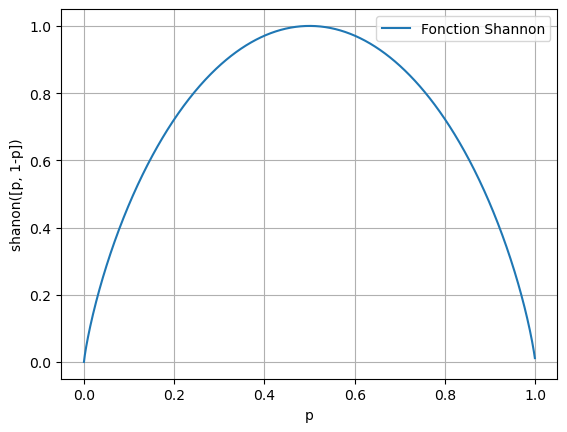

In [13]:
# Tracé de la courbe:

# --------------------------- Version Enseignants -----------
P = np.arange(0.0, 1.0, 0.001)
S = [shannon([p, 1-p]) for p in P]
plt.plot(P, S, label="Fonction Shannon")
plt.legend()
plt.xlabel('p')
plt.ylabel('shanon([p, 1-p])')
plt. grid()
plt.show()

<font color="RED" size="+1">**[Q]**</font> A l'aide de la fonction <code>shannon</code>, écrire la fonction <code>entropie</code> qui prend un ensemble de labels en argument et renvoie l'entropie de la distribution des classes dans cet ensemble.

In [14]:
# ------------------------ (CORRECTION POUR ENSEIGNANT)
def entropie(labels):
    """proba_list = []
    valeurs, nb_fois = np.unique(labels,return_counts=True)
    for j in nb_fois:
        proba_list.append(j/len(labels))
    return shannon(proba_list)"""
    _,nb_fois = np.unique(labels,return_counts=True)
    return shannon(nb_fois/len(labels))

In [15]:
# Exemple sur nos données :
entropie(elections_label)

0.9544340029249649

## Arbres de décision

Dans cette partie, on réalise l'implémentation de l'algorithme de construction d'un arbre de décision.

### Représentation d'un arbre en Python

<div class="alert alert-block alert-warning">
Pour représenter un arbre en Python, on a besoin de définir une structure de données adéquate. 

Un arbre de décision est défini par des **noeuds** qui sont de 2 types :
- *noeud interne* : c'est un noeud qui est associé à un attribut (ie. une feature de description des exemples) et qui possède des fils qui sont aussi des noeuds. 
- *feuille* : c'est un noeud qui est associé à un label de la classe et qui a la particularité de ne pas avoir de descendants.
</div>
Pour représenter des noeuds, nous définissons la classe `NoeudCategoriel` suivante:

In [16]:
# La librairie suivante est nécessaire pour l'affichage graphique de l'arbre:
import graphviz as gv

# Eventuellement, il peut être nécessaire d'installer graphviz sur votre compte:
# pip install --user --install-option="--prefix=" -U graphviz

class NoeudCategoriel:
    """ Classe pour représenter des noeuds d'un arbre de décision
    """
    def __init__(self, num_att=-1, nom=''):
        """ Constructeur: il prend en argument
            - num_att (int) : le numéro de l'attribut auquel il se rapporte: de 0 à ...
              si le noeud se rapporte à la classe, le numéro est -1, on n'a pas besoin
              de le préciser
            - nom (str) : une chaîne de caractères donnant le nom de l'attribut si
              il est connu (sinon, on ne met rien et le nom sera donné de façon 
              générique: "att_Numéro")
        """
        self.attribut = num_att    # numéro de l'attribut
        if (nom == ''):            # son nom si connu
            self.nom_attribut = 'att_'+str(num_att)
        else:
            self.nom_attribut = nom 
        self.Les_fils = None       # aucun fils à la création, ils seront ajoutés
        self.classe   = None       # valeur de la classe si c'est une feuille
        
    def est_feuille(self):
        """ rend True si l'arbre est une feuille 
            c'est une feuille s'il n'a aucun fils
        """
        return self.Les_fils == None
    
    def ajoute_fils(self, valeur, Fils):
        """ valeur : valeur de l'attribut de ce noeud qui doit être associée à Fils
                     le type de cette valeur dépend de la base
            Fils (NoeudCategoriel) : un nouveau fils pour ce noeud
            Les fils sont stockés sous la forme d'un dictionnaire:
            Dictionnaire {valeur_attribut : NoeudCategoriel}
        """
        if self.Les_fils == None:
            self.Les_fils = dict()
        self.Les_fils[valeur] = Fils
        # Rem: attention, on ne fait aucun contrôle, la nouvelle association peut
        # écraser une association existante.
    
    def ajoute_feuille(self,classe):
        """ classe: valeur de la classe
            Ce noeud devient un noeud feuille
        """
        self.classe    = classe
        self.Les_fils  = None   # normalement, pas obligatoire ici, c'est pour être sûr
        
    def classifie(self, exemple):
        """ exemple : numpy.array
            rend la classe de l'exemple (pour nous, soit +1, soit -1 en général)
            on rend la valeur 0 si l'exemple ne peut pas être classé (cf. les questions
            posées en fin de ce notebook)
        """
        if self.est_feuille():
            return self.classe
        if exemple[self.attribut] in self.Les_fils:
            # descente récursive dans le noeud associé à la valeur de l'attribut
            # pour cet exemple:
            return self.Les_fils[exemple[self.attribut]].classifie(exemple)
        else:
            # Cas particulier : on ne trouve pas la valeur de l'exemple dans la liste des
            # fils du noeud... Voir la fin de ce notebook pour essayer de résoudre ce mystère...
            print('\t*** Warning: attribut ',self.nom_attribut,' -> Valeur inconnue: ',exemple[self.attribut])
            return 0
    
    def to_graph(self, g, prefixe='A'):
        """ construit une représentation de l'arbre pour pouvoir l'afficher graphiquement
            Cette fonction ne nous intéressera pas plus que ça, elle ne sera donc pas expliquée            
        """
        if self.est_feuille():
            g.node(prefixe,str(self.classe),shape='box')
        else:
            g.node(prefixe, self.nom_attribut)
            i =0
            for (valeur, sous_arbre) in self.Les_fils.items():
                sous_arbre.to_graph(g,prefixe+str(i))
                g.edge(prefixe,prefixe+str(i), valeur)
                i = i+1        
        return g


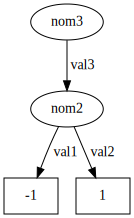

In [17]:
# Exemple d'utilisation: 
un_noeud0= NoeudCategoriel() 
un_noeud0.ajoute_feuille(-1)

un_noeud1= NoeudCategoriel()
un_noeud1.ajoute_feuille(+1)

un_noeud2= NoeudCategoriel(0,"nom2")
un_noeud2.ajoute_fils("val1",un_noeud0)
un_noeud2.ajoute_fils("val2",un_noeud1)

un_noeud3 = NoeudCategoriel(1,"nom3")
un_noeud3.ajoute_fils("val3",un_noeud2)

# L'affichage se fait en 2 temps
# 1) on initialise un graphe orienté :
gtree = gv.Digraph(format='png')
# 2) on le rempli en appelant la méthode de la classe NoeudCategoriel
un_noeud3.to_graph(gtree)

### Construction de l'arbre de décision

<div class="alert alert-block alert-warning">
Comme on l'a vu dans le cours, pour construire un arbre de décision à partir d'un dataset ($X$, $Y$), il faut réaliser les étapes suivantes:
    
1. calculer l'entropie de Shannon de l'ensemble des classes $Y$, on la note $H_S(Y)$.
    
2. si $H_S(Y)$ est inférieure à epsilon (qui est un réel positif donné en paramètre de l'algorithme), alors construire une feuille avec cet ensemble, la classe associée à cette feuille est la classe majoritaire dans $Y$.
    
3. sinon, pour chaque attribut $X_j$ qui décrit les exemples de $X$,
    
    3.1. pour chacune des valeurs $v_{jl}$ de $X_j$ construire l'ensemble des exemples de $X$ qui possède la valeur $v_{jl}$ ainsi que l'ensemble de leurs labels.
    
    3.2. calculer l'entropie conditionnelle de Shannon de la classe relativement à l'attribut $X_j$. On note $H_S(Y|X_j)$ cette entropie.    
    
    
4. l'attribut $X_{best}$ qui **maximise le gain d'information** est choisi pour constituer un nouveau noeud $\eta$ de l'arbre de décision:
    
    4.1. chaque valeur de $X_{best}$ est utilisée pour décomposer ($X$, $Y$) en autant de datasets que $X_{best}$ possède de valeurs: chaque dataset est séparant $X$ et $Y$ selon la valeur prise pour $X_{best}$. 
    
    4.2. pour chaque dataset obtenu on reprend en 1 pour construire chacun des fils de $\eta$. 


On rappelle que le gain d'information est:

$$I_S(X_j,Y) = H_S(Y) - H_S(Y|X_j)$$

On peut remarquer que chercher l'attribut $X_j$ qui **maximise le gain d'information** $I_S(X_j,Y)$ est équivalent à chercher $X_j$ qui **minimise l'entropie** $H_S(Y|X_j)$ (car le terme $H_S(Y)$ reste constant pour les calculs pour tous les attributs).
</div>

<font color="RED" size="+1">**[Q]**</font> Compléter la fonction `construit_AD`suivante afin qu'elle permette de construire un arbre de décision. Cette fonction rend un `NoeudCategoriel` qui correspond à l'arbre construit pour le dataset $(X,Y)$ donné.

In [18]:
def construit_AD(X,Y,epsilon,LNoms = []):
    """ X,Y : dataset
        epsilon : seuil d'entropie pour le critère d'arrêt 
        LNoms : liste des noms de features (colonnes) de description 
    """
    (nb_lignes, nb_colonnes) = X.shape
    entropie_ens = entropie(Y)
    if (entropie_ens <= epsilon):
        # ARRET : on crée une feuille
        noeud = NoeudCategoriel(-1,"Label")
        noeud.ajoute_feuille(classe_majoritaire(Y))
    else:
        min_entropie = 1.1
        i_best = -1
        Xbest_valeurs = None
        
        #############
        
        # COMPLETER CETTE PARTIE : ELLE DOIT PERMETTRE D'OBTENIR DANS
        # i_best : le numéro de l'attribut qui minimise l'entropie
        # min_entropie : la valeur de l'entropie minimale
        # Xbest_valeurs : la liste des valeurs que peut prendre l'attribut i_best
        #
        # Il est donc nécessaire ici de parcourir tous les attributs et de calculer
        # la valeur de l'entropie de la classe pour chaque attribut.
        
        
        ############
        
        for i in range(nb_colonnes):
            entropie_i = 0
            Xi = np.unique(X[:,i])
            for x in Xi:
                entropie_i += len(Y[X[:,i]==x])/len(Y)*entropie(Y[X[:,i]==x])
            if entropie_i < min_entropie:
                min_entropie = entropie_i
                i_best = i
                Xbest_valeurs = np.unique(X[:,i])
        
        if len(LNoms)>0:  # si on a des noms de features
            noeud = NoeudCategoriel(i_best,LNoms[i_best])    
        else:
            noeud = NoeudCategoriel(i_best)
        for v in Xbest_valeurs:
            noeud.ajoute_fils(v,construit_AD(X[X[:,i_best]==v], Y[X[:,i_best]==v],epsilon,LNoms))
    return noeud

La classe pour implémenter un arbre de décision dérive de la classe `Classifier`. Elle utilise la fonction `construit_AD` dans sa méthode `train` pour construire un arbre à partir d'un dataset donné.

<font color="RED" size="+1">**[Q]**</font> Compléter la classe suivante en donnant le code des méthodes `train` et `predict`.

**Remarque :** la méthode `score` ne fera rien dans notre cas, on verra dans un autre notebook comment on pourrait la définir.

In [19]:
class ClassifierArbreDecision(cl.Classifier):
    """ Classe pour représenter un classifieur par arbre de décision
    """
    
    def __init__(self, input_dimension, epsilon, LNoms=[]):
        """ Constructeur
            Argument:
                - intput_dimension (int) : dimension de la description des exemples
                - epsilon (float) : paramètre de l'algorithme (cf. explications précédentes)
                - LNoms : Liste des noms de dimensions (si connues)
            Hypothèse : input_dimension > 0
        """
        self.dimension = input_dimension
        self.epsilon = epsilon
        self.LNoms = LNoms
        # l'arbre est manipulé par sa racine qui sera un Noeud
        self.racine = None
        
    def toString(self):
        """  -> str
            rend le nom du classifieur avec ses paramètres
        """
        return 'ClassifierArbreDecision ['+str(self.dimension) + '] eps='+str(self.epsilon)
        
    def train(self, desc_set, label_set):
        """ Permet d'entrainer le modele sur l'ensemble donné
            desc_set: ndarray avec des descriptions
            label_set: ndarray avec les labels correspondants
            Hypothèse: desc_set et label_set ont le même nombre de lignes
        """        
        self.racine =construit_AD(desc_set, label_set, self.epsilon, self.LNoms)
    
    def score(self,x):
        """ rend le score de prédiction sur x (valeur réelle)
            x: une description
        """
        # cette méthode ne fait rien dans notre implémentation :
        pass
    
    def predict(self, x):
        """ x (array): une description d'exemple
            rend la prediction sur x             
        """
        return self.racine.classifie(x)

    def affiche(self,GTree):
        """ affichage de l'arbre sous forme graphique
            Cette fonction modifie GTree par effet de bord
        """
        self.racine.to_graph(GTree)

### Premières expérimentations

Apprentissage d'un arbre de décision avec la base sur les élections :

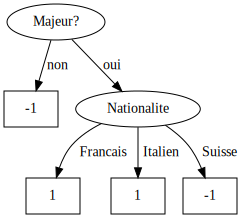

In [20]:
# Initialiation d'un arbre pour le dataset Elections:
arbre_elections = ClassifierArbreDecision(len(elections_noms), 0.0, elections_noms)

# Construction de l'arbre de décision à partir du dataset Elections
arbre_elections.train(elections_desc,elections_label)

# Construction de la représentation graphique (affichage)
graphe_arbre_elections = gv.Digraph(format='png')
arbre_elections.affiche(graphe_arbre_elections)

# Affichage du graphe obtenu:
graphe_arbre_elections

Pour classer un nouvel exemple avec un arbre de décision, on utilise la méthode <code>predict</code> qui utilise la méthode `classifie` de la classe `NoeudCategoriel` pour classer un nouvel exemple et renvoyer le label +1 ou -1 selon le cas. 

Exemple de classification d'un exemple avec l'arbre obtenu :

In [21]:
arbre_elections.predict(elections_desc[0,:])

1

Classification d'un nouvel exemple qui n'appartient à pas au dataset d'apprentissage :

In [362]:
# Rappel : elections_noms = ['Adresse', 'Majeur?', 'Nationalite']
arbre_elections.predict(np.array(['Paris','oui','Italien']))

1

Mesure de l'accuracy de l'arbre obtenu :

In [363]:
arbre_elections.accuracy(elections_desc,elections_label)

1.0

## Première expérimentation avec la base Mushrooms

Pour mieux évaluer notre nouvel algortithme d'apprentissage, on va utiliser la base des champignons `mushrooms-1000.csv` qui est fournie dans le répertoire `data`. Ce dataset est une version réduite du dataset original qui comporte plus de 8000 champignons.



Dans le répertorie `data/` fourni avec ce sujet, vous pouvez trouver 6 fichiers `mushrooms-****.csv`. Ces 6 fichiers ont été obtenus en partitionant le fichier orignal `mushrooms.csv` que l'on peut trouver sur internet. Dans cette base originale, il y a 8124 champignons recensés. Ce fichier original a été découpé en 5 fichiers de 1400 champignons et 1 fichier de 1124 champignons. L'union de ces 6 fichiers permet donc de recomposer le fichier original.


### Construction d'un arbre de décision

Dans un premier temps, on vérifie que notre algorithme d'apprentissage fonctionne correctement en construisant un arbre de décision à partir d'un des fichiers.

On commence par charger le fichier dans un dataframe et on le transforme en dataset (cf. le notebook précédent pour le détail des étapes):

In [364]:
# Chargement des fichiers de données sur les mushrooms:

# On commence par travailler sur un des fichier "mushrooms-1400"
mushrooms_df = pd.read_csv("data/mushrooms-1400-1.csv")

mushrooms_df


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,y,n,f,y,f,c,n,b,...,s,p,w,p,w,o,e,w,v,d
1,p,x,s,n,f,y,f,c,n,b,...,k,p,w,p,w,o,e,w,v,l
2,p,x,f,y,f,f,f,c,b,g,...,k,b,p,p,w,o,l,h,v,d
3,p,x,f,y,f,f,f,c,b,g,...,k,n,b,p,w,o,l,h,y,g
4,p,x,f,y,f,f,f,c,b,h,...,k,p,b,p,w,o,l,h,y,d
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,p,x,y,e,f,f,f,c,n,b,...,k,w,w,p,w,o,e,w,v,p
1396,e,f,y,n,t,n,f,c,b,p,...,s,w,g,p,w,o,p,k,v,d
1397,e,f,f,e,t,n,f,c,b,n,...,s,p,g,p,w,o,p,n,y,d
1398,p,x,f,y,f,f,f,c,b,p,...,k,n,b,p,w,o,l,h,y,d


In [365]:
# Dans ce dataframe, la colonne de classe s'appelle 'class'
mushrooms_noms = [nom for nom in mushrooms_df.columns if nom != 'class']

# Passer du dataframe à un dataset (2 arrays desc & labels):
mushrooms_1_desc = np.array(mushrooms_df[mushrooms_noms])
mushrooms_1_label = np.array(mushrooms_df['class'])


Ensuite, on construit l'arbre de décision correspondant.

<font color="RED" size="+1">**[Q]**</font> Compléter le code suivant pour apprendre l'arbre et l'afficher ensuite:

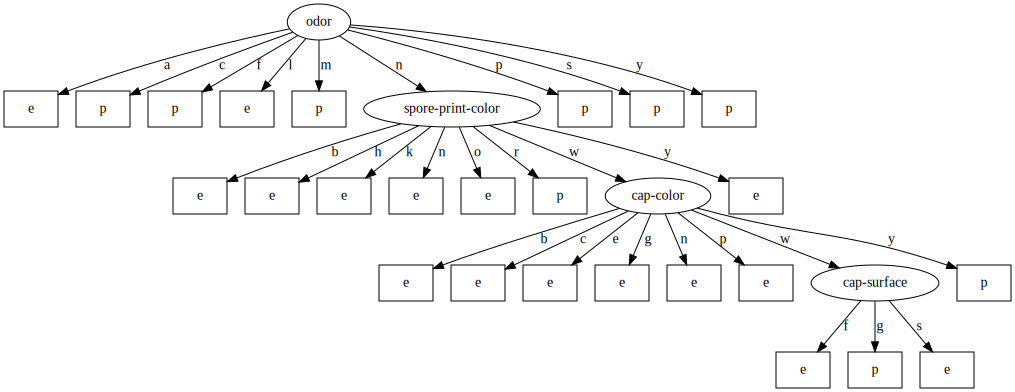

In [366]:
# construction de l'arbre de décision à partir du dataset Elections:
arbre_mushrooms_1 = ClassifierArbreDecision(len(mushrooms_noms), 0.0, mushrooms_noms)

# Construction de l'arbre de décision à partir du dataset Mushrooms
arbre_mushrooms_1.train(mushrooms_1_desc,mushrooms_1_label)


# Construction de la représentation graphique (affichage)
gr_arbre_mushrooms_1 = gv.Digraph(format='png')
arbre_mushrooms_1.affiche(gr_arbre_mushrooms_1)

# Affichage du graphe obtenu:
gr_arbre_mushrooms_1

### Classification avec l'arbre de décision obtenu

Exemple de classification d'un exemple:

In [367]:
arbre_mushrooms_1.predict(mushrooms_1_desc[0,:])

'p'

Calcul de l'accuracy sur le dataset d'apprentissage.

**Attention**: la fonction `accuracy` doit pouvoir tenir compte du fait que les classes ne sont pas égales à +1 ou -1 comme c'était le cas jusqu'à présent, il peut donc être nécessaire de redéfinir cette méthode dans la classe 
`ClassifierArbreDecision`: *la classification d'un exemple est correcte, si la fonction `predict`rend sa vraie classe.*


In [368]:
arbre_mushrooms_1.accuracy(mushrooms_1_desc,mushrooms_1_label)

1.0

<font color="RED" size="+1">**[Q]**</font> Toujours avec le dataset `mushrooms_1` précédent, construire un nouvel arbre de décision en utilisant comme valeur d'epsilon : $0.25$.

Que constatez-vous ? 

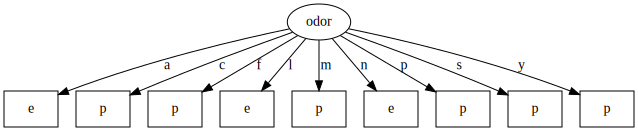

In [369]:
arbre_mushrooms_1_bis = ClassifierArbreDecision(len(mushrooms_noms), 0.25, mushrooms_noms)

# Construction de l'arbre de décision à partir du dataset Mushrooms
arbre_mushrooms_1_bis.train(mushrooms_1_desc,mushrooms_1_label)


# Construction de la représentation graphique (affichage)
gr_arbre_mushrooms_1_bis = gv.Digraph(format='png')
arbre_mushrooms_1_bis.affiche(gr_arbre_mushrooms_1_bis)



# Affichage du graphe obtenu:
gr_arbre_mushrooms_1_bis

<font color="RED" size="+1">**[Q]**</font> Déterminer l'accuracy de ce nouvel arbre.


In [370]:
arbre_mushrooms_1_bis.accuracy(mushrooms_1_desc,mushrooms_1_label)

0.9892857142857143

<font color="RED" size="+1">**[Q]**</font> D'après ces résultats, de ces 2 arbres, quel est celui qui a sur-appris ? 

L'arbre qui a sur-appris est l'arbre mushroom_1 

## Plus d'expérimentations avec la base Mushrooms

On décide maintenant d'évaluer plus en détail ce nouvel algorithme. On souhaite:
1. construire un arbre avec chaque fichier `mushrooms-1400-*.csv` 
2. pour chaque arbre construit, évaluer son accuracy:
    - sur le dataset d'apprentissage
    - sur les 4 autres fichiers `mushrooms-1400-*.csv`
    - sur le fichier `mushrooms-1124.csv`
    
    
**Remarque :** normalement, tous ces tests devraient pouvoir se faire dans un temps raisonnable, dans le cas contraire, faites les un par un.

In [371]:
# Chargement des fichiers mushrooms et apprentissage
mushrooms_desc = []
mushrooms_label = []
arbres_mushrooms = []
for j in range(0,5):
    mushrooms_df = pd.read_csv("data/mushrooms-1400-"+str(j+1)+".csv")
    mushrooms_noms = [nom for nom in mushrooms_df.columns if nom != 'class']
    # Passer du dataframe à un dataset (2 arrays):
    mushrooms_desc.append(np.array(mushrooms_df[mushrooms_noms]))
    mushrooms_label.append(np.array(mushrooms_df['class']))
    
    # Apprentissage
    arbres_mushrooms.append(ClassifierArbreDecision(len(mushrooms_noms), 0.0, mushrooms_noms))
    arbres_mushrooms[j].train(mushrooms_desc[j],mushrooms_label[j])

In [372]:
# Fichier qui va nous servir à tester
mushrooms_df = pd.read_csv("data/mushrooms-1124.csv")

# Passer du dataframe à un dataset (2 arrays):
mushrooms_test_desc = np.array(mushrooms_df[mushrooms_noms])
mushrooms_test_label = np.array(mushrooms_df['class'])

<font color="RED" size="+1">**[Q]**</font> Donner les instructions permettant d'obtenir le taux de bonne classification (accuracy) de chacun des arbres construits sur les autres bases, sur le modèle suivant:

In [373]:
for k in range(5):
    print("Apprentissage avec mushrooms-1400-", k+1)
    for g in range(5): 
        print("   classification de mushrooms-1400- ",g+1, " : ", arbres_mushrooms[k].accuracy(mushrooms_desc[g],mushrooms_label[g]))
    print("   --> classification de mushrooms-1124 : ", arbres_mushrooms[k].accuracy(mushrooms_test_desc,mushrooms_test_label))

Apprentissage avec mushrooms-1400- 1
   classification de mushrooms-1400-  1  :  1.0
   classification de mushrooms-1400-  2  :  1.0
   classification de mushrooms-1400-  3  :  0.9964285714285714
	*** Warning: attribut  cap-surface  -> Valeur inconnue:  y
	*** Warning: attribut  cap-surface  -> Valeur inconnue:  y
	*** Warning: attribut  cap-surface  -> Valeur inconnue:  y
   classification de mushrooms-1400-  4  :  0.9957142857142857
   classification de mushrooms-1400-  5  :  0.9971428571428571
	*** Warning: attribut  cap-surface  -> Valeur inconnue:  y
   --> classification de mushrooms-1124 :  0.9955516014234875
Apprentissage avec mushrooms-1400- 2
   classification de mushrooms-1400-  1  :  0.9985714285714286
   classification de mushrooms-1400-  2  :  1.0
   classification de mushrooms-1400-  3  :  0.9964285714285714
   classification de mushrooms-1400-  4  :  0.9957142857142857
   classification de mushrooms-1400-  5  :  0.9964285714285714
   --> classification de mushrooms-1124

<font color="RED" size="+1">**[Q]**</font> On peut remarquer que pour certains arbres, la classification de certains exemples produit un warning.
En étudiant les exemples suivant et leur classification par le premier arbre, expliquez pourquoi un warning se produit.
Est-ce normal ? Pourrait-on trouver une solution pour ces cas-là ?


In [374]:
for i in range(0,1400):
    prediction = arbres_mushrooms[0].predict(mushrooms_desc[3][i,:])
    if prediction == 0:
        print(i," --> pas de prédiction, le label rendu est ",prediction)


	*** Warning: attribut  cap-surface  -> Valeur inconnue:  y
962  --> pas de prédiction, le label rendu est  0
	*** Warning: attribut  cap-surface  -> Valeur inconnue:  y
1219  --> pas de prédiction, le label rendu est  0
	*** Warning: attribut  cap-surface  -> Valeur inconnue:  y
1349  --> pas de prédiction, le label rendu est  0


In [375]:
mushrooms_1_df = pd.read_csv("data/mushrooms-1400-1.csv")
mushrooms_1_noms = [nom for nom in mushrooms_1_df.columns if nom != 'class']

# Passer du dataframe à un dataset (2 arrays desc & labels):
mushrooms_1_desc = np.array(mushrooms_1_df[mushrooms_1_noms])
mushrooms_1_label = np.array(mushrooms_1_df['class'])

print(mushrooms_1_label)

['p' 'p' 'p' ... 'e' 'p' 'e']


<font color="RED" size="+1">**[Q]**</font> Réaliser une validation croisée en 10 paquets sur la base mushrooms_1, puis sur la base mushrooms complète.

In [394]:
#MUSHROOMS_1
mushrooms_1_df = pd.read_csv("data/mushrooms-1400-1.csv")

# Dans ce dataframe, la colonne de classe s'appelle 'class'
mushrooms_1_noms = [nom for nom in mushrooms_1_df.columns if nom != 'class']

# Passer du dataframe à un dataset (2 arrays desc & labels):
mushrooms_1_desc = np.array(mushrooms_1_df[mushrooms_1_noms])
mushrooms_1_label = np.array(mushrooms_1_df['class'])

###################### A COMPLETER 
arbre = ClassifierArbreDecision(len(mushrooms_1_noms), 0.0, mushrooms_1_noms)
arbre.train(mushrooms_1_desc, mushrooms_1_label)
#################################


# Remarque: j'ai mis des affichage dans la fonction validation croisée afin de montrer
# ce qui se passe:
(res_all, res_moy, res_sd) = validation_croisee(arbre, (mushrooms_1_desc, mushrooms_1_label), 10)

print("Validation croisée sur mushrooms 1")
print("Perf obtenues : ",res_all)
print("Accuracy moyenne: ",res_moy,"\técart type: ", res_sd)

Validation croisée sur mushrooms 1
Perf obtenues :  [1.0, 1.0, 0.9856115107913669, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Accuracy moyenne:  0.9985611510791367 	écart type:  0.004316546762589935


In [395]:
#MUSHROOMS_2
mushrooms_2_df = pd.read_csv("data/mushrooms-1400-2.csv")

# Dans ce dataframe, la colonne de classe s'appelle 'class'
mushrooms_2_noms = [nom for nom in mushrooms_2_df.columns if nom != 'class']

# Passer du dataframe à un dataset (2 arrays desc & labels):
mushrooms_2_desc = np.array(mushrooms_2_df[mushrooms_2_noms])
mushrooms_2_label = np.array(mushrooms_2_df['class'])

###################### A COMPLETER 
arbre = ClassifierArbreDecision(len(mushrooms_2_noms), 0.0, mushrooms_2_noms)
arbre.train(mushrooms_2_desc, mushrooms_2_label)
#################################


# Remarque: j'ai mis des affichage dans la fonction validation croisée afin de montrer
# ce qui se passe:
(res_all, res_moy, res_sd) = validation_croisee(arbre, (mushrooms_2_desc, mushrooms_2_label), 10)

print("Validation croisée sur mushrooms 2")
print("Perf obtenues : ",res_all)
print("Accuracy moyenne: ",res_moy,"\técart type: ", res_sd)

	*** Warning: attribut  odor  -> Valeur inconnue:  m
	*** Warning: attribut  odor  -> Valeur inconnue:  m
Validation croisée sur mushrooms 2
Perf obtenues :  [1.0, 1.0, 1.0, 1.0, 1.0, 0.9856115107913669, 1.0, 1.0, 1.0, 1.0]
Accuracy moyenne:  0.9985611510791367 	écart type:  0.004316546762589935


<font color="RED" size="+1">**[Q]**</font> Regrouper les 6 fichiers mushrooms et réaliser une évaluation de l'algorithme de construction d'arbres par une validation croisée en 10 paquets.

In [377]:
# regroupement des fichiers
mushrooms_all_df = pd.concat([pd.read_csv("data/mushrooms-1400-1.csv"), 
                          pd.read_csv("data/mushrooms-1400-2.csv"), 
                          pd.read_csv("data/mushrooms-1400-3.csv"), 
                          pd.read_csv("data/mushrooms-1400-4.csv"), 
                          pd.read_csv("data/mushrooms-1400-5.csv"), 
                          pd.read_csv("data/mushrooms-1124.csv")])

# Dans ce dataframe, la colonne de classe s'appelle 'class'
mushrooms_noms = [nom for nom in mushrooms_all_df.columns if nom != 'class']

# Passer du dataframe à un dataset (2 arrays desc & labels):
mushrooms_desc = np.array(mushrooms_all_df[mushrooms_noms])
mushrooms_label = np.array(mushrooms_all_df['class'])

# arbre de décision
arbre = ClassifierArbreDecision(len(mushrooms_desc), 0.0, mushrooms_noms)

(res_all, res_moy, res_sd) = validation_croisee(arbre, (mushrooms_desc, mushrooms_label), 10)

print("Validation croisée sur tous les mushrooms")
print("Perf obtenues : ",res_all)
print("Accuracy moyenne: ",res_moy,"\técart type: ", res_sd)

Validation croisée sur tous les mushrooms
Perf obtenues :  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Accuracy moyenne:  1.0 	écart type:  0.0


## Evaluation "Leave one out"

Nous avons vu 2 approches pour évaluer un algorithme d'apprentissage:
- la mesure de l'accuracy sur les données d'apprentissage et sur une base de test
- la réalisation d'une validation croisée pour mesurer l'accuracy et l'écart type (pour évaluer la robustesse) mesurées sur les données utilisées pour apprendre le modèle (données d'apprentissage) et sur des données qui n'ont pas été utilisées pour mettre au point le modèle (données test)

La première approche est généralement utilisée pour comparer plusieurs modèles en regardant leur accuracy sur les mêmes données de test.
La deuxième approche est, elle, utilisée pour aussi obtenir une certaine évaluation de la robustesse du modèle appris et garantir que l'accuracy mesurée n'est pas simplement obtenue sur "un cas particulier" de données.

Cependant, il existe des cas où le dataset que l'on possède ne contient pas beaucoup d'exemples. Dans ce cas, deux possibilités:
- il y a suffisament de données dans le dataset pour réaliser une validation croisée en réduisant le nombre de paquets (ie. prendre 4 paquets au lieu de 10 par exemple);
- il y a trop peu d'exemples pour qu'une validation croisée soit réalisable, on utilise alors une autre technique d'évaluation: l'évaluation par **leave one out** (littéralement: "en mettre un de côté"). 


<div class="alert alert-block alert-warning">
    L'évaluation par <b>leave one out</b> procède ainsi: à partir d'un dataset $DS$ contenant $n$ exemples:
    
1. sortir un des exemples de $DS$ et le mettre de côté
    
2. apprendre le modèle sur les $n-1$ exemples non sortis de $DS$
    
3. tester le modèle appris sur l'exemple mis de côté: il est soit bien classé (on marque 1 pt), soit mal classé (on marque 0 pt)
    
4. prendre le $DS$ original est choisir un exemple différent à mettre de côté
    
5. reprendre en 1) 

Les étapes 4) et 5) sont faites jusqu'à ce que tous les exemples de $DS$ aient été sortis à leur tour de $DS$.
A la fin, l'accuracy de test du modèle est alors donnée par le ratio $\frac{\mbox{nombre de points marqués}}{n}$.

</div>    

<i>Remarque</i>: le plus simple dans cette approche, c'est de sortir les exemples en les prenant dans l'ordre dans lequel ils sont dans le dataset.
    

<font color="RED" size="+1">**[Q]**</font> Ecrire la fonction `leave_one_out` qui prend en argument un algorithme d'apprentissage $C$ et un dataset $DS$ et rend l'accuracy de test de $C$ calculée sur $DS$ en utilisant l'évaluation par leave one out.

**Remarque**: il peut être important de copier (correctement) le classifieur pour pouvoir l'entraîner plusieurs fois.

In [378]:
import copy  # pour utiliser copy.deepcopy() qui permet de faire des copies de C 

# ------------------------ A COMPLETER :
def leave_one_out(C, DS):
    """ Classifieur * tuple[array, array] -> float
    """
    desc_set,label_set = DS
    index_list =[i for i in range(len(desc_set))]
    np.random.shuffle(index_list)
    cpt = 0
    for i in index_list:
        ci = copy.deepcopy(C)
        ci.train(np.delete(desc_set, i, 0), np.delete(label_set, i))
        cpt += 1 if ci.predict(desc_set[i])==label_set[i] else 0
    return cpt/len(desc_set)

Tester avec la base sur les élections européennes:

In [379]:
# Chargement et préparation du dataset:
elections_df = pd.read_csv("data/elections.csv")
elections_noms = [nom for nom in elections_df.columns if nom != 'Label']

data_desc = np.array(elections_df[elections_noms])
data_label = np.array(elections_df['Label'])

# Lancement du leave one out
leave_one_out(ClassifierArbreDecision(len(elections_noms), 0.1, elections_noms),(data_desc,data_label))

	*** Warning: attribut  Nationalite  -> Valeur inconnue:  Italien


0.75

## Comparaison avec d'autres algorithmes

Afin de pouvoir comparer les autres classifieurs que l'on a vu précédemment avec celui par arbres de décision, il faut les adapter afin qu'ils puissent traiter les données catégorielles.
En cours, nous avons vu l'encodage one-hot qui s'implémente en python avec la fonction `get_dummies` de la librairie `pandas` (cf. cours 6).


### Base des élections

<font color="RED" size="+1">**[Q]**</font> En utilisant la fonction `get_dummies` tranformer le dataframe `elections_df` en un dataframe `elections_df_num` qui ne contient que des attributs numériques.

In [380]:
# Rappel :
print("Noms des colonnes : ", elections_noms)
elections_df


Noms des colonnes :  ['Adresse', 'Majeur?', 'Nationalite']


,Adresse,Majeur?,Nationalite,Label
0,Paris,oui,Francais,1
1,Paris,non,Francais,-1
2,Montpellier,oui,Italien,1
3,Paris,oui,Suisse,-1
4,Strasbourg,non,Italien,-1
5,Strasbourg,non,Francais,-1
6,Strasbourg,oui,Francais,1
7,Montpellier,oui,Suisse,-1


In [381]:
# ############################### A COMPLETER 
elections_df_num = pd.get_dummies(elections_df, elections_noms)
# ------------------------
elections_df_num

,Label,Adresse_Montpellier,Adresse_Paris,Adresse_Strasbourg,Majeur?_non,Majeur?_oui,Nationalite_Francais,Nationalite_Italien,Nationalite_Suisse
0,1,0,1,0,0,1,1,0,0
1,-1,0,1,0,1,0,1,0,0
2,1,1,0,0,0,1,0,1,0
3,-1,0,1,0,0,1,0,0,1
4,-1,0,0,1,1,0,0,1,0
5,-1,0,0,1,1,0,1,0,0
6,1,0,0,1,0,1,1,0,0
7,-1,1,0,0,0,1,0,0,1


In [382]:
# Prétraitement pour pouvoir utiliser un classifieur
elections_num_noms = [nom for nom in elections_df_num.columns if nom != 'Label']

print("Noms des features: ",elections_num_noms)

# Passer du dataframe à des arrays:
elections_num_desc = np.array(elections_df_num[elections_num_noms])
elections_num_label = np.array(elections_df_num['Label'])

# Transformer le dataframe en dataset:
data_num_desc = np.array(elections_df_num[elections_num_noms])
data_num_label = np.array(elections_df_num['Label'])


Noms des features:  ['Adresse_Montpellier', 'Adresse_Paris', 'Adresse_Strasbourg', 'Majeur?_non', 'Majeur?_oui', 'Nationalite_Francais', 'Nationalite_Italien', 'Nationalite_Suisse']


<font color="RED" size="+1">**[Q]**</font> Réaliser un `leave_one_out` sur cette base (même paramétrage que celui pour la base catégorielle) et comparer le résultat avec celui obtenu dans le cas catégoriel. Commenter.

In [383]:
le_dataset = (data_num_desc,data_num_label)

# Lancement du leave one out
leave_one_out(ClassifierArbreDecision(len(elections_num_noms), 0.1, elections_num_noms),le_dataset)

0.875

On a une meilleure accuracy de test pour la base à données numériques.

<font color="RED" size="+1">**[Q]**</font> Toujours sur cette base, réaliser un `leave_one_out` avec le classifieur KNN. Tester différentes valeurs de $k$ et tracer le résultat obtenu.

/home/noura/Licence/LU3IN026/tme-06/../iads/Classifiers.py:105: RuntimeWarning: overflow encountered in ubyte_scalars
  somme += (desc[i][j] - x[j])**2


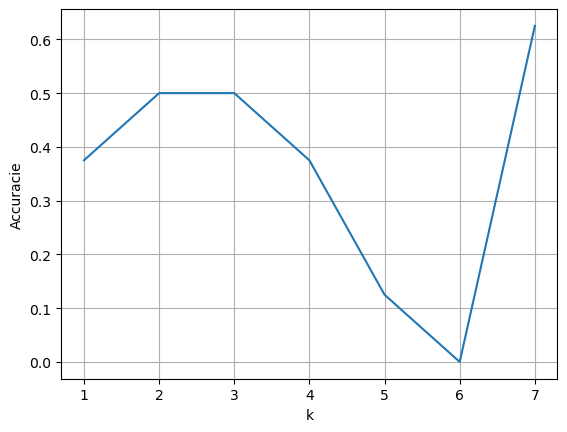

In [384]:
accuracies = []
valeurs_k = range(1,8)
for k in(valeurs_k):
    accuracies.append(leave_one_out(cl.ClassifierKNN(len(elections_num_noms),k),le_dataset))
plt.plot(valeurs_k ,accuracies )
plt.xlabel('k')
plt.ylabel('Accuracie')
plt.grid(True)
plt.show()

### Base des champignons

<font color="RED" size="+1">**[Q]**</font> Réaliser un ensemble d'expérimentations sur la base mushrooms permettant de comparer les résultats obtenus avec un classifieur par arbres de décision et les classifieurs numériques que l'on a définis dans les séances précédentes.

**Remarque**: commencer par une taille de base réduite pour que cela ne prenne pas trop de temps d'exécution...

In [387]:
# regroupement des fichiers
mushrooms_all_df = pd.concat([pd.read_csv("data/mushrooms-1400-1.csv"), 
                          pd.read_csv("data/mushrooms-1400-2.csv"), 
                          pd.read_csv("data/mushrooms-1400-3.csv"), 
                          pd.read_csv("data/mushrooms-1400-4.csv"), 
                          pd.read_csv("data/mushrooms-1400-5.csv"), 
                          pd.read_csv("data/mushrooms-1124.csv")])

# Dans ce dataframe, la colonne de classe s'appelle 'class'
mushrooms_noms = [nom for nom in mushrooms_all_df.columns if nom != 'class']

# Passer du dataframe à un dataset (2 arrays desc & labels):
mushrooms_desc = np.array(mushrooms_all_df[mushrooms_noms])
mushrooms_label = np.array(mushrooms_all_df['class'])

# arbre de décision
arbre = ClassifierArbreDecision(len(mushrooms_desc), 0.0, mushrooms_noms)

(res_all, res_moy, res_sd) = validation_croisee(arbre, (mushrooms_desc, mushrooms_label), 10)

print("Validation croisée sur tous les mushrooms")
print("Perf obtenues : ",res_all)
print("Accuracy moyenne: ",res_moy,"\técart type: ", res_sd)# Rechargement de la base de départ :

# On commence par travailler sur un des fichier "mushrooms-1400"
mushrooms_df = pd.read_csv("data/mushrooms-1400-1.csv")
# Dans ce dataframe, la colonne de classe s'appelle 'class'
mushrooms_noms = [nom for nom in mushrooms_df.columns if nom != 'class']


Validation croisée sur tous les mushrooms
Perf obtenues :  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Accuracy moyenne:  1.0 	écart type:  0.0


In [388]:
mushrooms_1_num = pd.get_dummies(mushrooms_df, columns = mushrooms_noms)
mushrooms_1_num 

,class,cap-shape_b,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,p,0,0,0,0,1,0,0,0,1,...,0,1,0,1,0,0,0,0,0,0
1,p,0,0,0,0,1,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0
2,p,0,0,0,0,1,1,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,p,0,0,0,0,1,1,0,0,0,...,0,0,1,0,1,0,0,0,0,0
4,p,0,0,0,0,1,1,0,0,0,...,0,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,p,0,0,0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
1396,e,0,1,0,0,0,0,0,0,1,...,0,1,0,1,0,0,0,0,0,0
1397,e,0,1,0,0,0,1,0,0,0,...,0,0,1,1,0,0,0,0,0,0
1398,p,0,0,0,0,1,1,0,0,0,...,0,0,1,1,0,0,0,0,0,0


In [389]:
# Prétraitement pour pouvoir utiliser un classifieur
mushrooms_1_num_noms = [nom for nom in mushrooms_1_num.columns if nom != 'class']

print("Noms des features: ",mushrooms_1_num_noms)

# Passer du dataframe à des arrays:
mushrooms_1_num_desc = np.array(mushrooms_1_num[mushrooms_1_num_noms])
mushrooms_1_num_label = np.array(mushrooms_1_num['class'])

# Transformer le dataframe en dataset:
data_num_desc = np.array(mushrooms_1_num[mushrooms_1_num_noms])

# Remarque : pour utiliser les classifieurs précédents, il faut que la classe soit +1 ou -1
# on convertit donc 'e' et 'p'
val_class ={'e':1, 'p':-1}
data_num_label = np.array([val_class[c] for c in mushrooms_1_num['class']])


Noms des features:  ['cap-shape_b', 'cap-shape_f', 'cap-shape_k', 'cap-shape_s', 'cap-shape_x', 'cap-surface_f', 'cap-surface_g', 'cap-surface_s', 'cap-surface_y', 'cap-color_b', 'cap-color_c', 'cap-color_e', 'cap-color_g', 'cap-color_n', 'cap-color_p', 'cap-color_r', 'cap-color_u', 'cap-color_w', 'cap-color_y', 'bruises_f', 'bruises_t', 'odor_a', 'odor_c', 'odor_f', 'odor_l', 'odor_m', 'odor_n', 'odor_p', 'odor_s', 'odor_y', 'gill-attachment_a', 'gill-attachment_f', 'gill-spacing_c', 'gill-spacing_w', 'gill-size_b', 'gill-size_n', 'gill-color_b', 'gill-color_e', 'gill-color_g', 'gill-color_h', 'gill-color_k', 'gill-color_n', 'gill-color_o', 'gill-color_p', 'gill-color_r', 'gill-color_u', 'gill-color_w', 'gill-color_y', 'stalk-shape_e', 'stalk-shape_t', 'stalk-root_?', 'stalk-root_b', 'stalk-root_c', 'stalk-root_e', 'stalk-root_r', 'stalk-surface-above-ring_f', 'stalk-surface-above-ring_k', 'stalk-surface-above-ring_s', 'stalk-surface-above-ring_y', 'stalk-surface-below-ring_f', 'stalk

In [390]:
print("Exemple de résultat sur les données numériques: validation croisée avec les arbres de décisions")

arbre = ClassifierArbreDecision(len(mushrooms_1_num_noms), 0.1, mushrooms_1_num_noms)

# Remarque: j'ai mis des affichage dans la fonction validation croisée afin de montrer
# ce qui se passe:
(res_all, res_moy, res_sd) = validation_croisee(arbre, (data_num_desc, data_num_label), 10)

print("Perf obtenues : ",res_all)
print("Accuracy moyenne: ",res_moy,"\técart type: ", res_sd)

Exemple de résultat sur les données numériques: validation croisée avec les arbres de décisions
Perf obtenues :  [1.0, 1.0, 0.9784172661870504, 0.9928057553956835, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Accuracy moyenne:  0.9971223021582734 	écart type:  0.006593634093461631


In [391]:
k=3
print("Exemple de résultat: validation croisée avec un knn pour k=",k)



Exemple de résultat: validation croisée avec un knn pour k= 3


In [392]:
print("Exemple de résultat: validation croisée avec un perceptron biais")

# ############################### A COMPLETER 
perceptrion_biais = cl.ClassifierPerceptronBiais(len(mushrooms_1_num_noms))

(res_all, res_moy, res_sd) = validation_croisee(perceptrion_biais, (data_num_desc, data_num_label), 10)

print("Perf obtenues : ",res_all)
print("Accuracy moyenne: ",res_moy,"\técart type: ", res_sd)

Exemple de résultat: validation croisée avec un perceptron biais
Perf obtenues :  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Accuracy moyenne:  1.0 	écart type:  0.0


<font color="RED" size="+1">**[Q]**</font> *Toujours plus...*  

Réaliser les mêmes expérimentations avec la base mushrooms complète.